# This module will host Data Cleaning, Statistics and EDA

In [23]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
df_train = pd.read_csv('Data/train_users_2.csv')
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


## Data Cleaning

1. Replacing missing data with -1
2. Removing erroneous ages

In [11]:
# Replacing missing values with -1
df_train.index = df_train.id
df_train = df_train.fillna(-1)
df_train = df_train.replace('-unknown-', -1)

# Removing erroneous ages
df_train.age.loc[df_train.age < 15] = np.nan
df_train.age.loc[df_train.age > 100] = np.nan

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Inferential Statistics
Inorder to understand what data we are dealing with and discovering any relationships between the features

**1. Gender preference for Airbnb bookings**  

This checks whether the gender of a person affects the first booking he/she makes.

**2. SignUp preferences**

This checks whether the sign up device effects the sign up method


### Gender preference for Airbnb bookings
This checks whether the gender of a person affects the first booking he/she makes. In order to answer this we need to test the relationship between two variables gender and destination country (both categorical). Since the dependent variable(destination countries) is multivariate, Chi Square Significance test will be used

Few **assumptions** before we perform some statistics here:
- Only people who enlisted their gender as male and female are considered.
- We will not consider any users who haven't booked, and people who have booked under the enlisted titles other and NDF

In [34]:
df_gen_stats = df_train[(df_train['country_destination'] != 'NDF') & (df_train['country_destination'] != 'other') & (df_train['gender'] != -1 ) & (df_train['gender'] != "OTHER" ) & (df_train['gender'].notnull())]
df_gen_stats = df_gen_stats[['id', 'gender', 'country_destination']]
df_gen_stats.head()

,id,gender,country_destination
id,,,
4ft3gnwmtx,4ft3gnwmtx,FEMALE,US
lsw9q7uk0j,lsw9q7uk0j,FEMALE,US
0d01nltbrs,0d01nltbrs,FEMALE,US
a1vcnhxeij,a1vcnhxeij,FEMALE,US
yuuqmid2rp,yuuqmid2rp,FEMALE,US


In [35]:
df_gen_stats['gender'].value_counts()

FEMALE    28833
MALE      24278
Name: gender, dtype: int64

In [36]:
df_gen_stats['country_destination'].value_counts()

US    42151
FR     3297
IT     1790
GB     1563
ES     1530
CA      932
DE      774
NL      532
AU      395
PT      147
Name: country_destination, dtype: int64

### Hypothesis Testing
**Null Hypothesis:** There is no relationship between the gender of a person to the choosen destination country  
**Alternate Hypothesis:** There is a relationship between the gender of a person to the choosen destination country

Assuming significance level of alpha as 0.05

In [19]:
observed = df_gen_stats.pivot_table('id', ['gender'], 'country_destination', aggfunc='count').reset_index()
del observed.columns.name
observed = observed.set_index('gender')
observed

,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
gender,,,,,,,,,,
FEMALE,207,455,358,853,1962,881,1091,254,78,22694
MALE,188,477,416,677,1335,682,699,278,69,19457


In [24]:
chi2_1, p_1, dof, expected = stats.chi2_contingency(observed)
print(chi2_1, p_1)

116.871831396 5.83012695507e-21


Since the p-value is less than the significance level, we can reject the null hypothesis.   
This means **There is a relationship between gender and the first country booked.**

### SignUp preference for Airbnb bookings
This checks whether the type of device affects the sign up method to Airbnb. Both the Chi Square Significance Test and the Z-Statistic Test (as sample size > 30) are performed. If performed correctly, both tests should give us the same results.

Few **assumptions** before we perform some statistics here:
- Ignoring the google signup as they are very few.
- We will only consider iOS, Moweb and Android to be device types

In [28]:
df_signup = df_train[(df_train['signup_method'] != 'google')][['id', 'signup_method', 'signup_app']]
df_signup['device'] = df_signup['signup_app'].apply(lambda x: 'Computer' if x == 'Web' else 'Mobile')
df_signup.head()

,id,signup_method,signup_app,device
id,,,,
gxn3p5htnn,gxn3p5htnn,facebook,Web,Computer
820tgsjxq7,820tgsjxq7,facebook,Web,Computer
4ft3gnwmtx,4ft3gnwmtx,basic,Web,Computer
bjjt8pjhuk,bjjt8pjhuk,facebook,Web,Computer
87mebub9p4,87mebub9p4,basic,Web,Computer


In [37]:
df_signup['signup_method'].value_counts()


basic       152897
facebook     60008
Name: signup_method, dtype: int64

In [38]:
df_signup['device'].value_counts()

Computer    182717
Mobile       30188
Name: device, dtype: int64

### Hypothesis Testing
**Null Hypothesis:** There is no relationship between the signup device and signup method.  
**Alternate Hypothesis:** There is a relationship between the signup device and signup method. 

Assuming significance level of alpha as 0.05


In [39]:
df_signup = df_signup.pivot_table('id', ['device'], 'signup_method', aggfunc='count')
df_signup.index = ['Computer', 'Mobile']
df_signup.columns = ['Basic', 'Facebook']
df_signup

,Basic,Facebook
Computer,131237,51480
Mobile,21660,8528


#### Chi Square Test

In [40]:
chi2_2, p_2, dof, expected = stats.chi2_contingency(df_signup, correction=False)
print(chi2_2,p_2)

0.0718382427342 0.788678866102


Since the p-value is greater than the significance level, we can accept the null hypothesis.   
This means **There is no relationship between the signup device and signup method.**  
Let us now analyze using Z-Statistic Test to see if we get the same results.

#### Two Sample Significance Test
Utilizing the same hypothesis

In [41]:
df_signup.loc['Total'] = [ df_signup['Basic'].sum(), df_signup['Facebook'].sum()]
df_signup['Total'] = df_signup['Basic'] + df_signup['Facebook']
df_signup

,Basic,Facebook,Total
Computer,131237,51480,182717
Mobile,21660,8528,30188
Total,152897,60008,212905


In [42]:
fb_prop = df_signup.loc['Mobile', 'Facebook']/df_signup.loc['Total', 'Facebook']
fb_std = df_signup.loc['Mobile', 'Facebook'] * ((1 - fb_prop) ** 2) + df_signup.loc['Computer', 'Facebook'] * ((0 - fb_prop) ** 2)
fb_std = np.sqrt(fb_std/df_signup.loc['Total', 'Facebook'])

fb_prop, fb_std

(0.14211438474870017, 0.34916741886407238)

In [50]:
basic_prop = df_signup.loc['Mobile', 'Basic']/df_signup.loc['Total', 'Basic']
basic_std = df_signup.loc['Mobile', 'Basic'] * ((1 - basic_prop) ** 2) + df_signup.loc['Computer', 'Basic'] * ((0 - basic_prop) ** 2)
basic_std = np.sqrt(basic_std/df_signup.loc['Total', 'Basic'])

basic_prop, basic_std

(0.14166399602346677, 0.34870518816635054)

In [51]:
h0_prop = 0

prop_diff = fb_prop - basic_prop
p_hat = (df_signup.loc['Mobile', 'Basic'] + df_signup.loc['Mobile', 'Facebook'])/(df_signup.loc['Total', 'Basic'] + df_signup.loc['Total', 'Facebook']) 
var_diff = p_hat * (1- p_hat) * (1/df_signup.loc['Total', 'Basic'] + 1/df_signup.loc['Total', 'Facebook'])
sigma_diff = np.sqrt(var_diff)

prop_diff, sigma_diff

(0.00045038872523339712, 0.001680388342245922)

In [52]:
z = (prop_diff - h0_prop) / sigma_diff
z

0.26802657094813592

In [53]:
p = (1-stats.norm.cdf(z))*2
p

0.78867886610237936

Since the p-value is greater than the significance level, we can accept the null hypothesis.   
This means **There is no relationship between the signup device and signup method.** Note that, both the chi square and Z-statistic had the same result. 

#### Statistical Conclusions
**1. There is a relationship between gender and the first country booked**  
**2. There is no relationship between the signup device and signup method**

## EDA

**1. Let us analyze how the distance of the destination country influences the booking frequency.**    
We will construct scatter plots between the distance from the origin country to the frequency of destination country visited.  
**2. Let us analyze how the language of the destination country influences the booking frequency.**   
We will construct scatter plots between the language_levenshtein_distance of destination country to the frequency of destination country visited.  
**3. Let us analyze how the size of the destination country influences the booking frequency.**   
We will construct scatter plots between the area of destination country to the frequency of destination country visited.

**4. Median age of travellers from each destination country.**   
A boxplot between age and country is constructed using the data from training set
    

In [54]:
df_con = pd.read_csv('Data/countries.csv')
df_con

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


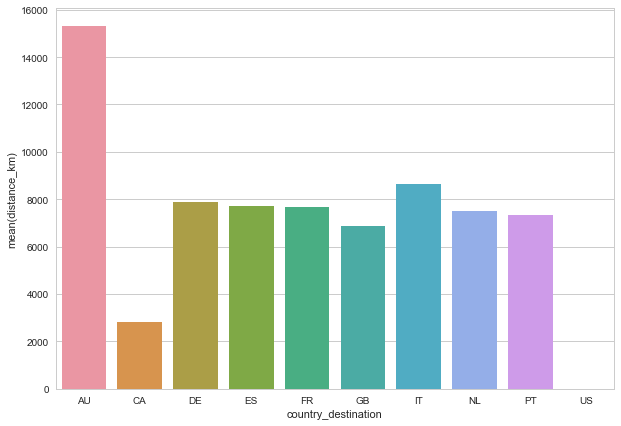

In [55]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.barplot(x='country_destination', y='distance_km', data=df_con)

The above visualization shows distance of destination country from the origin country (US). That being said the distance from US to AU (australia) is quite far.

### How distance of the destination country influences the booking frequency

In [64]:
# Number of times each destination country is visited
country_popularity = df_train[(df_train['country_destination'] != 'NDF') 
                              & (df_train['country_destination'] != 'other')]['country_destination'].value_counts()

In [65]:
# Distance of destination country from Origin Country (US)
country_distance = pd.Series(df_con['distance_km'])
country_distance.index = df_con['country_destination']

In [66]:
# How different is each country in terms the language each destination country mostly speaks
language_distance = pd.Series(df_con['language_levenshtein_distance'])
language_distance.index = df_con['country_destination']

In [67]:
# Destination country area
country_area = pd.Series(df_con['destination_km2'])
country_area.index = df_con['country_destination']

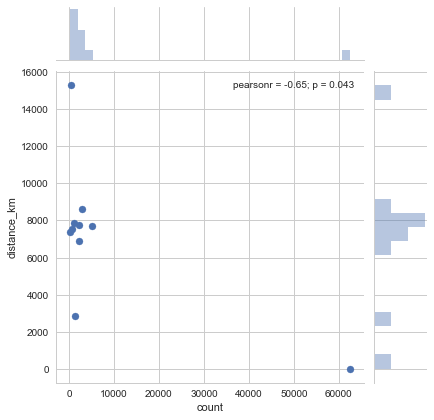

In [68]:
df_dp = pd.concat([country_popularity, country_distance, language_distance, country_area], axis=1)
df_dp.columns = ['count', 'distance_km', 'language', 'area']
sns.jointplot(x='count', y='distance_km', data=df_dp)

The **strong negative correlation of -0.65** between distance and booking frequency tells us that people don't prefer to travel too long from the origin country. What would be the stats if US is removed from the destination country.

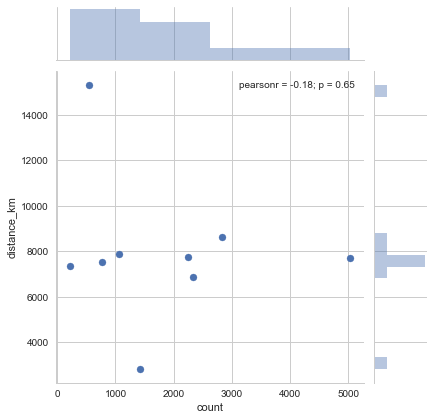

In [71]:
sns.jointplot(x='count', y='distance_km', data=df_dp.drop('US'))

The **correlation is much lower at -0.18**, however it is still negatively correlated between two quantiles. This agains tells us that people don't prefer to travel too long.

### How the language of the destination country influences the booking frequency.

To analyze this we will use the language_levenshtein_distance of each language from english(given metric)

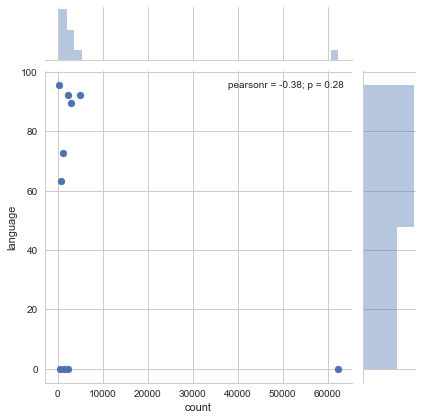

In [72]:
sns.jointplot(x='count', y='language', data=df_dp)

The **low negative correlation of -0.38** between language and count tells us that people prefer mostly english speaking countries to travel first.  

The right most point must be US, its language score is 0 and it has most of the counts.  What would be the stats if US is removed from the destination country.  


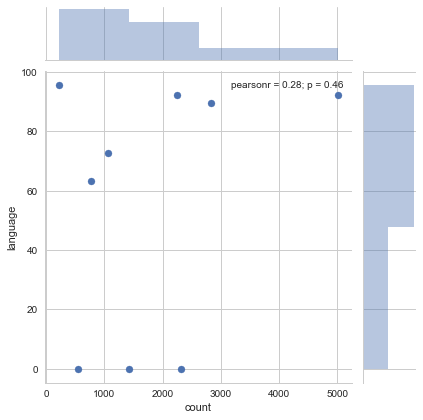

In [74]:
sns.jointplot(x='count', y='language', data=df_dp.drop('US'))

The result of this is extremely interesting:  
1. After removing United States from the list, we see that there is positive correlation between language and booking frequency.  
2. Majority of the users prefer countries with different languages, excluding United states.
3. Looking at other point of view, it means that **Americans prefer travelling to European countries**, than to english speaking countries like Canada and Australia

### How Size of the destination country influences the booking frequency

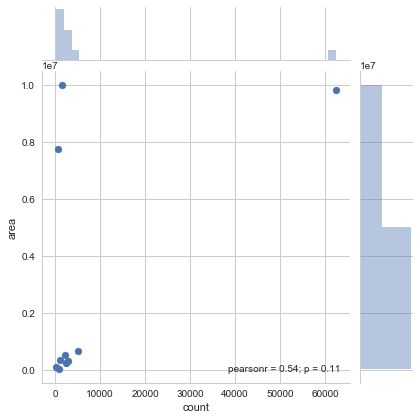

In [75]:
sns.jointplot(x='count', y='area', data=df_dp)

Overall we can see positive correlation between size of country to booking frequency. This might be because of Unites states country size, which is quite larger than most of the european nations. What would be the stats if US is removed from the destination country.  

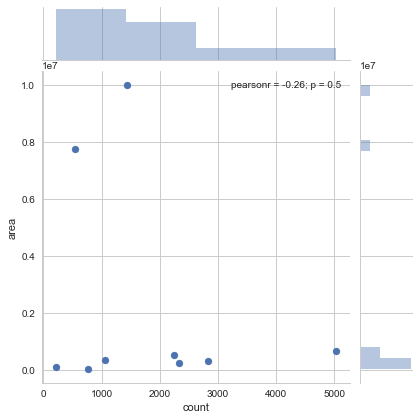

In [77]:
sns.jointplot(x='count', y='area', data=df_dp.drop('US'))

This again brings back the **negative correlation between size and booking frequency**. As with the case of size, the size of the country does not influence the destination country. 

### Median age of travellers from each destination country

(10, 75)

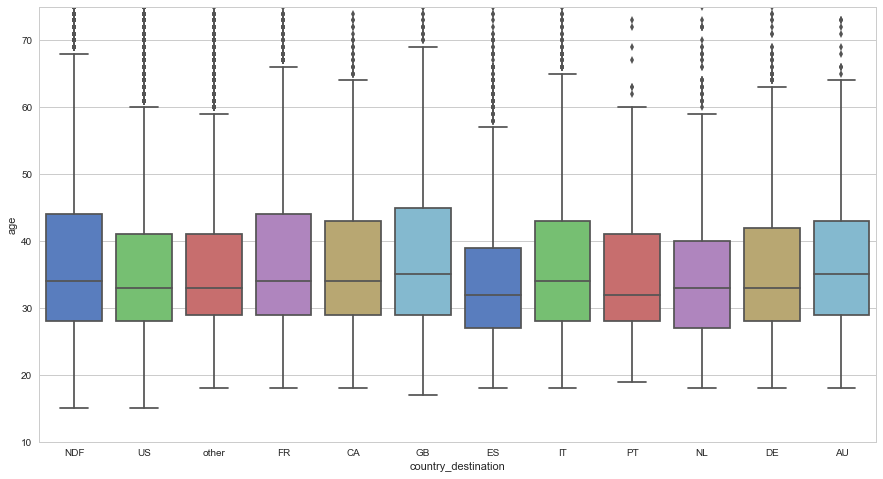

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='country_destination', y='age', data=df_train, palette="muted", ax =ax)
ax.set_ylim([10, 75])

**This shows that, the median age of travellers is high in Great Britain, and more younsters travel in spain.**

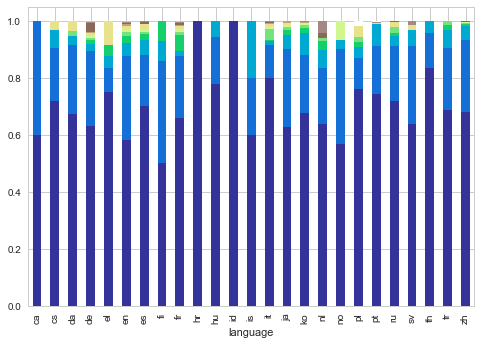

In [82]:
# Here in each Stacked Bar each bar represent a class(a destination country). 
# The bottom bar(dark blue) corresponds to NDF
# The second bottom bar(blue) corresponds to US
classes = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']
def stacked_viz(feature):
    ctab = pd.crosstab([df_train[feature].fillna('Unknown')], df_train.country_destination, dropna=False).apply(lambda x: x/x.sum(), axis=1)
    ctab[classes].plot(kind='bar', stacked=True, colormap='terrain', legend=False)
    
stacked_viz('language')

We see that people who speak **Hungarian and Indonesian made almost no bookings**. People who spoke **Finnish made the most bookings** amongst all languages. 

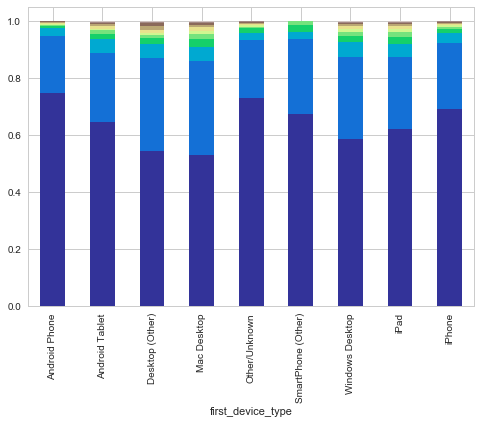

In [83]:
stacked_viz('first_device_type')

**This makes it clear that Mac desktop users have made most of the bookings**

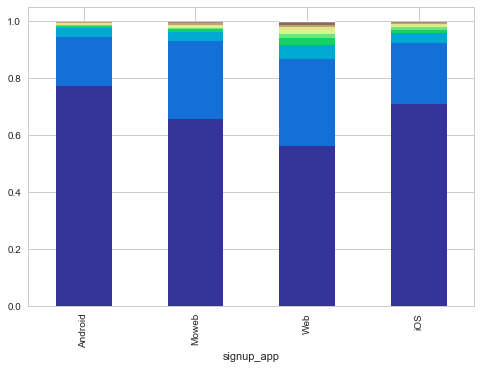

In [84]:
stacked_viz('signup_app')

**This makes it clear that most of the users have made most of the bookings using the web app, whereas android users are less likely to book**

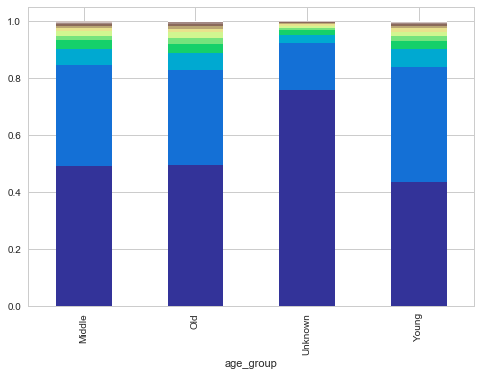

In [85]:
def set_age_group(x):
    if x < 40:
        return 'Young'
    elif x >=40 and x < 60:
        return 'Middle'
    elif x >= 60 and x <= 125:
        return 'Old'
    else:
        return 'Unknown'
df_train['age_group'] = df_train['age'].apply(set_age_group)
stacked_viz('age_group')

**This tells us that, who haven't disclosed their age are less likely to make a booking. Possibly because they would be surfing the Airbnb's**

## **Final observations:**
- There is a relationship between gender and the first country booked.
- There is no relationship between the signup device and signup method.
- People don't prefer to travel too long.
- Majority of the users prefer countries with different languages, excluding United states. From the 3rd and 4th points it means more likely Americans prefer travelling to European countries, than to english speaking countries like Canada and Australia
- The size of the country does not influence the destination country.
- Median age of travellers is high in Great Britain, and more younsters travel in spain.
- Hungarian and Indonesian's made almost no bookings.
- Finnish users made the most bookings.
- Mac desktop users have made most of the bookings
- Most of the bookings have been made through Airbnb Webapp
- Who haven't disclosed their age are less likely to make a booking.